In [ ]:
!pip install transformers
!pip install diffusers
!pip install accelerate

In [ ]:
from transformers import ViTForImageClassification
from PIL import Image, ImageDraw, ImageFont
import numpy as np
from transformers import ViTFeatureExtractor
import torch
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt

In [ ]:
vit = ViTForImageClassification.from_pretrained("oschamp/vit-artworkclassifier")
vit.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vit.to(device)

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

In [ ]:
model_id = "CompVis/stable-diffusion-v1-4"
device = "cuda"

pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to(device)

def original_generate(prompt, seed):
    generator = torch.Generator("cuda").manual_seed(seed)
    # return pipe(prompt, generator=generator).images[0]
    #faster generation
    # generator = torch.Generator("cuda").manual_seed(1024)
    return pipe(prompt, num_inference_steps=10, generator=generator).images[0]

In [ ]:
def vit_classify(image):
    encoding = feature_extractor(images=image, return_tensors="pt")
    encoding.keys()

    pixel_values = encoding['pixel_values'].to(device)

    outputs = vit(pixel_values)
    logits = outputs.logits

    prediction = logits.argmax(-1)
    return prediction.item() #vit.config.id2label[prediction.item()]
    # print("Predicted class:", vit.config.id2label[prediction.item()])

def plotImagesAndLabels(image_list, prompts, classes):
    fig, m_axs = plt.subplots(3, 3, figsize = (20, 20))
    for i, c_ax in enumerate(m_axs.flatten()):
        c_ax.imshow(image_list[i], vmin = -1.5, vmax = 1.5)
        c_ax.set_title(prompts[i] + "\n" + "Class: " + classes[i])
        c_ax.set_xlabel("Class: " + classes[i])
        c_ax.axis('off')
    fig.show()
    plt.show()

In [ ]:
#-----------------------------------------------------------
art_name = "Starry Night"
seed = 0
#-----------------------------------------------------------
#grid of 9 artists
famous_artists = ['Vincent Van Gogh', 'Vincent Van Gogh', 'Claude Oscar Monet', 'Rembrandt Van Rijn', 'Michelangelo Buonarroti', 'Salvador Dali', 'Leonardo Da Vinci', 'Henri Matisse', 'Pablo Picasso']

#random names
#famous_artists = ['Bob', 'Dave', 'Sam', 'Charles', 'Oliver', 'Sean', 'Tom', 'Joe', 'Guy']
#famous_artists = ['Bob', 'Bob', 'Bob', 'Bob', 'Bob', 'Bob', 'Bob', 'Bob', 'Bob']

prompts = []
for artist in famous_artists:
    p = art_name + " by " + artist
    prompts.append(p)

L = len(famous_artists)
prompts = prompts[:L]

first_9_famousartists = []
first_9_prompts = []
first_9_classes = []
for i, prompt in enumerate(prompts):
    s = seed
    print("Artist: ", famous_artists[i])
    image2 = finetuned_generate(prompt)
    #solving the NSFW issue
    while np.array(image2).mean() == 0:
        s += 1
        image2 = original_generate(prompt, s)
    class2 = vit_classify(image2)
    if i < 9:
        first_9_famousartists.append(image2)
        first_9_prompts.append(prompt)
        first_9_classes.append(vit.config.id2label[class2])

plotImagesAndLabels(first_9_famousartists, first_9_prompts, first_9_classes)

In [ ]:
model_path = "oschamp/pytorch_artwork_lora_finetuned"
pipe_ft = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16)
pipe_ft.unet.load_attn_procs(model_path)
pipe_ft.to("cuda")

In [ ]:
def finetuned_generate(prompt):
    # return pipe_ft(prompt).images[0]
    #faster generation
    return pipe_ft(prompt, num_inference_steps=10).images[0]

In [ ]:
#-----------------------------------------------------------
art_name = "Starry Night"
#-----------------------------------------------------------
#grid of 9 artists
famous_artists = ['Vincent Van Gogh', 'Vincent Van Gogh', 'Claude Oscar Monet', 'Rembrandt Van Rijn', 'Michelangelo Buonarroti', 'Salvador Dali', 'Leonardo Da Vinci', 'Henri Matisse', 'Pablo Picasso']

#random names
#famous_artists = ['Bob', 'Dave', 'Sam', 'Charles', 'Oliver', 'Sean', 'Tom', 'Joe', 'Guy']
#famous_artists = ['Bob', 'Bob', 'Bob', 'Bob', 'Bob', 'Bob', 'Bob', 'Bob', 'Bob']

prompts = []
for artist in famous_artists:
    p = art_name + " by " + artist
    prompts.append(p)

L = len(famous_artists)
prompts = prompts[:L]

first_9_famousartists = []
first_9_prompts = []
first_9_classes = []
for i, prompt in enumerate(prompts):
    print("Artist: ", famous_artists[i])
    image2 = finetuned_generate(prompt)
    #solving the NSFW issue
    while np.array(image2).mean() == 0:
        image2 = finetuned_generate(prompt)
    class2 = vit_classify(image2)
    if i < 9:
        first_9_famousartists.append(image2)
        first_9_prompts.append(prompt)
        first_9_classes.append(vit.config.id2label[class2])

plotImagesAndLabels(first_9_famousartists, first_9_prompts, first_9_classes)

Full Inference Steps, Fixed Random Seed at Generation

In [ ]:
def finetuned_generate(prompt, seed):
    generator = torch.Generator("cuda").manual_seed(seed)
    # return pipe_ft(prompt).images[0]
    #faster generation
    return pipe_ft(prompt, generator=generator).images[0]

Artist:  Vincent Van Gogh


  0%|          | 0/50 [00:00<?, ?it/s]

Artist:  Claude Oscar Monet


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Artist:  Rembrandt Van Rijn


  0%|          | 0/50 [00:00<?, ?it/s]

Artist:  Michelangelo Buonarroti


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Artist:  Salvador Dali


  0%|          | 0/50 [00:00<?, ?it/s]

Artist:  Leonardo Da Vinci


  0%|          | 0/50 [00:00<?, ?it/s]

Artist:  Henri Matisse


  0%|          | 0/50 [00:00<?, ?it/s]

Artist:  Pablo Picasso


  0%|          | 0/50 [00:00<?, ?it/s]

Artist:  Jackson Pollock


  0%|          | 0/50 [00:00<?, ?it/s]

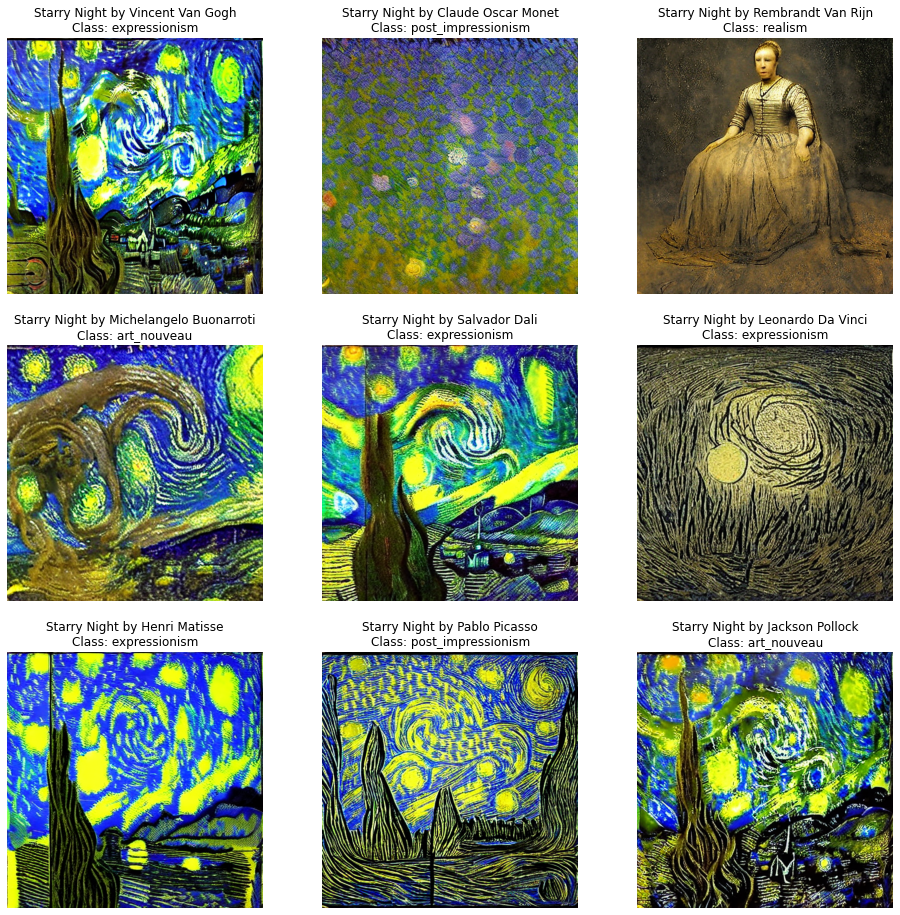

In [ ]:
#-----------------------------------------------------------
art_name = "Starry Night"
seed = 42
#-----------------------------------------------------------
#grid of 9 artists
famous_artists = ['Vincent Van Gogh', 'Claude Oscar Monet', 'Rembrandt Van Rijn', 'Michelangelo Buonarroti', 'Salvador Dali', 'Leonardo Da Vinci', 'Henri Matisse', 'Pablo Picasso', 'Jackson Pollock']

#random names
#famous_artists = ['Bob', 'Dave', 'Sam', 'Charles', 'Oliver', 'Sean', 'Tom', 'Joe', 'Guy']
#famous_artists = ['Bob', 'Bob', 'Bob', 'Bob', 'Bob', 'Bob', 'Bob', 'Bob', 'Bob']

prompts = []
for artist in famous_artists:
    p = art_name + " by " + artist
    prompts.append(p)

L = len(famous_artists)
prompts = prompts[:L]

first_9_famousartists = []
first_9_prompts = []
first_9_classes = []
for i, prompt in enumerate(prompts):
    s = seed
    print("Artist: ", famous_artists[i])
    image2 = finetuned_generate(prompt, s)
    #solving the NSFW issue
    while np.array(image2).mean() == 0:
        s += 1
        image2 = finetuned_generate(prompt, s)
    class2 = vit_classify(image2)
    if i < 9:
        first_9_famousartists.append(image2)
        first_9_prompts.append(prompt)
        first_9_classes.append(vit.config.id2label[class2])

plotImagesAndLabels(first_9_famousartists, first_9_prompts, first_9_classes)